# Performance Metrics of Butler's microservices backend

Testing the 4 main components of the backend:

- API Gateway
- AI Service
- Chat Service
- Identity Service

Load testing was done using [JMeter](https://jmeter.apache.org/). The test plan is available in the `load_testing` directory.

In [122]:
import pandas as pd
import os

request_dfs = {}
all_stats_dfs = {}

# agregate_9.csv
#timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
#1717158083210,12,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,12,0,1
#1717158083223,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0
#1717158083210,20,Chats,200,OK,Chats Thread Group 3-1,text,true,,4076,445,1,3,http://localhost:8080/chats,20,0,1
#1717158083227,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0
#1717158083232,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0
#1717158083236,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0
#1717158083230,12,Chats,200,OK,Chats Thread Group 3-1,text,true,,4076,445,1,3,http://localhost:8080/chats,12,0,0
#1717158083241,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0
#1717158083245,4,Models,200,OK,Models Thread Group 2-1,text,true,,6124,446,1,3,http://localhost:8080/models,4,0,0

# statistics_36.csv
#Models,13439,111,102,192,197,205,2,318,0.119%,138.15756,825.67,60.10
#Chats,9821,153,180,203,207,290,4,322,0.163%,100.96223,401.63,43.80
#Login,1255,302,301,398,404,492,14,591,0.319%,12.90210,12.86,6.51
#TOTAL,24515,138,108,202,279,389,2,591,0.147%,252.01748,1240.15,110.41

# columns are: Label, # Samples, Average, Median, 90% Line, 95% Line, 99% Line, Min, Max, Error %, Throughput, Received KB/sec, Sent KB/sec

# Read in aggregate_<connection_number>.csv in current directory

for file in os.listdir('.'):
    if file.startswith("aggregate_") and file.endswith(".csv"):
        df = pd.read_csv(file)
        # Get connection number
        connection_number = int(file.split('_')[1].split('.')[0])
        request_dfs[connection_number] = df

    if file.startswith("statistics_") and file.endswith(".csv"):
        df = pd.read_csv(file, header=None)
        df.columns = ['Type', 'Samples', 'Average', 'Median', '90%', '95%', '99%', 'Min', 'Max', 'Error%', 'Throughput request/sec', 'Received KB/sec', 'Sent KB/sec']
        # Get connection number
        connection_number = int(file.split('_')[1].split('.')[0])
        all_stats_dfs[connection_number] = df


C:\Users\illya\AppData\Local\Temp\ipykernel_506332\2056295825.py:31: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\illya\AppData\Local\Temp\ipykernel_506332\2056295825.py:31: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


# Complex queries performance

Queries include:

- Login request with 1 thread from identity service through api gateway
- Get all chats for user with 4 threads from chat service through api gateway
- Get all available models with 4 thread from ai service through api gateway

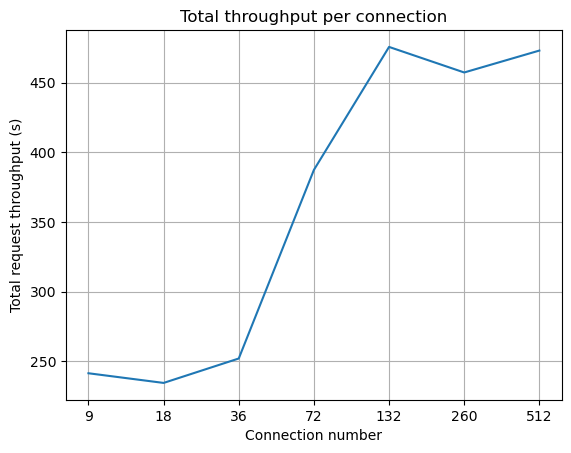

In [123]:
import matplotlib.pyplot as plt

request_throughput_per_connection = {}
for connection_number, df in request_dfs.items():
    duration = (max(df['timeStamp']) - min(df['timeStamp'])) / 1000
    request_throughput_per_connection[connection_number] = len(df) / duration

sorted_request_throughput_per_connection = sorted(request_throughput_per_connection.items())

plt.figure()
plt.grid()
plt.plot([str(x[0]) for x in sorted_request_throughput_per_connection], [x[1] for x in sorted_request_throughput_per_connection])
plt.xticks([str(x[0]) for x in sorted_request_throughput_per_connection])
# plt.yticks([x[1] for x in sorted_request_throughput_per_connection])
plt.xlabel('Connection number')
plt.ylabel('Total request throughput (s)')
plt.title('Total throughput per connection')
plt.show()

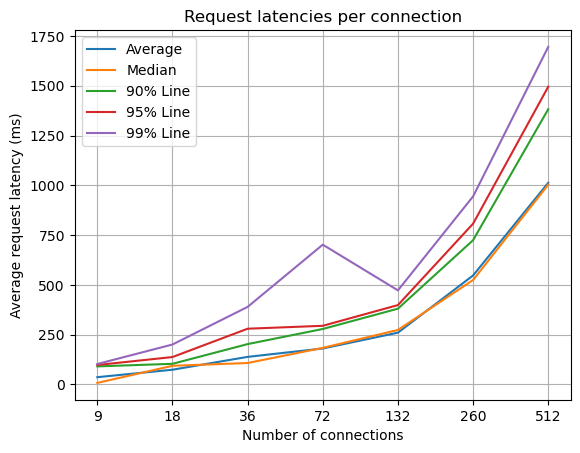

In [124]:
# Latency

request_latency_per_connection = {}
for connection_number, df in request_dfs.items():
    request_latency_per_connection[connection_number] = {
        'Average': df['Latency'].mean(),
        'Median': df['Latency'].median(),
        '90% Line': df['Latency'].quantile(0.9),
        '95% Line': df['Latency'].quantile(0.95),
        '99% Line': df['Latency'].quantile(0.99),
    }

sorted_request_latency_per_connection = sorted(request_latency_per_connection.items())
plt.figure()
plt.grid()

for percentile in ['Average', 'Median', '90% Line', '95% Line', '99% Line']:
    plt.plot([str(x[0]) for x in sorted_request_latency_per_connection], [x[1][percentile] for x in sorted_request_latency_per_connection], label=percentile)

plt.xticks([str(x[0]) for x in sorted_request_latency_per_connection])
plt.legend()
# plt.yticks([x[1] for x in sorted_request_latency_per_connection])
plt.xlabel('Number of connections')
plt.ylabel('Average request latency (ms)')
plt.title('Request latencies per connection')
plt.show()

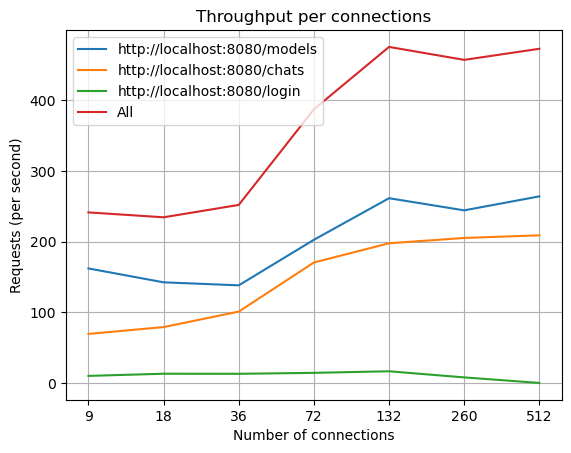

In [125]:
# Throughput per endpoint

request_throughput_per_connection_endpoint = {}
for connection_number, df in request_dfs.items():
    duration = (max(df['timeStamp']) - min(df['timeStamp'])) / 1000
    url_throughput = {}
    for url in df['URL'].unique():
        url_df = df[df['URL'] == url]
        url_throughput[url] = len(url_df) / duration
    request_throughput_per_connection_endpoint[connection_number] = url_throughput

sorted_request_throughput_per_connection_endpoint = sorted(request_throughput_per_connection_endpoint.items())

plt.figure()
plt.grid()

for url in df['URL'].unique():
    plt.plot([str(x[0]) for x in sorted_request_throughput_per_connection_endpoint], [x[1].get(url, 0) for x in sorted_request_throughput_per_connection_endpoint], label=url)

plt.plot([str(x[0]) for x in sorted_request_throughput_per_connection], [x[1] for x in sorted_request_throughput_per_connection], label='All')

plt.xticks([str(x[0]) for x in sorted_request_throughput_per_connection])
# plt.yticks([x[1] for x in sorted_request_throughput_per_connection])
plt.xlabel('Number of connections')
plt.ylabel('Requests (per second)')
plt.title('Throughput per connections')
plt.legend()
plt.show()

In [126]:
sorted_all_stats_dfs_based_on_connection = sorted(all_stats_dfs.items())
for x in sorted_all_stats_dfs_based_on_connection:
    # set name
    print(x[1].to_latex(index=False, column_format='lrrrrrrrrllrr', float_format="%.2f", caption=f"Statistics for {x[0]} connections", label=f"tab:stats_connections_{x[0]}"))

\begin{table}
\caption{Statistics for 36 connections}
\label{tab:stats_connections_36}
\begin{tabular}{lrrrrrrrrllrr}
\toprule
Type & Samples & Average & Median & 90% & 95% & 99% & Min & Max & Error% & Throughput request/sec & Received KB/sec & Sent KB/sec \\
\midrule
Models & 13439 & 111 & 102 & 192 & 197 & 205 & 2 & 318 & 0.119% & 138.16 & 825.67 & 60.10 \\
Chats & 9821 & 153 & 180 & 203 & 207 & 290 & 4 & 322 & 0.163% & 100.96 & 401.63 & 43.80 \\
Login & 1255 & 302 & 301 & 398 & 404 & 492 & 14 & 591 & 0.319% & 12.90 & 12.86 & 6.51 \\
TOTAL & 24515 & 138 & 108 & 202 & 279 & 389 & 2 & 591 & 0.147% & 252.02 & 1240.15 & 110.41 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Statistics for 72 connections}
\label{tab:stats_connections_72}
\begin{tabular}{lrrrrrrrrllrr}
\toprule
Type & Samples & Average & Median & 90% & 95% & 99% & Min & Max & Error% & Throughput request/sec & Received KB/sec & Sent KB/sec \\
\midrule
Models & 21923 & 152 & 164 & 218 & 283 & 305 & 2 & 481 &

In [127]:
all_stats_dfs_with_connection = all_stats_dfs.copy()
for connection_number, df in all_stats_dfs_with_connection.items():
    df['Concurrent connections'] = connection_number
    # Make concurrent connections the 2nd column
    cols = df.columns.tolist()
    new_cols = [cols[0], cols[-1]] + cols[2:-1]
    all_stats_dfs_with_connection[connection_number] = df[new_cols]

sorted_all_stats_dfs_based_on_connection = sorted(all_stats_dfs_with_connection.items())
all_stats_df = pd.concat([x[1] for x in sorted_all_stats_dfs_based_on_connection])

print(all_stats_df.to_latex(index=False, column_format='lrrrrrrrrrlrrr', float_format="%.2f", caption="All statistics", label="tab:all_stats", escape=True))

\begin{table}
\caption{All statistics}
\label{tab:all_stats}
\begin{tabular}{lrrrrrrrrrlrrr}
\toprule
Type & Concurrent connections & Average & Median & 90\% & 95\% & 99\% & Min & Max & Error\% & Throughput request/sec & Received KB/sec & Sent KB/sec \\
\midrule
Models & 36 & 111 & 102 & 192 & 197 & 205 & 2 & 318 & 0.119\% & 138.16 & 825.67 & 60.10 \\
Chats & 36 & 153 & 180 & 203 & 207 & 290 & 4 & 322 & 0.163\% & 100.96 & 401.63 & 43.80 \\
Login & 36 & 302 & 301 & 398 & 404 & 492 & 14 & 591 & 0.319\% & 12.90 & 12.86 & 6.51 \\
TOTAL & 36 & 138 & 108 & 202 & 279 & 389 & 2 & 591 & 0.147\% & 252.02 & 1240.15 & 110.41 \\
Models & 72 & 152 & 164 & 218 & 283 & 305 & 2 & 481 & 0.146\% & 202.55 & 1210.29 & 88.09 \\
Chats & 72 & 182 & 191 & 285 & 296 & 371 & 9 & 501 & 0.173\% & 170.43 & 677.97 & 73.94 \\
Login & 72 & 548 & 200 & 1600 & 1927 & 2509 & 4 & 15191 & 75.162\% & 14.25 & 5.34 & 7.17 \\
TOTAL & 72 & 180 & 183 & 278 & 294 & 702 & 2 & 15191 & 2.918\% & 387.22 & 1893.55 & 169.19 \\
Login & 